In [1]:
from astropy.time import Time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.units as u

import kepler_solver

In [2]:
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.6 * fs,
          'ytick.labelsize': 0.6 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

In [3]:
planet = pd.read_csv("mystery_planet01.txt", sep="\t", names=["time", "rv", "error"])
planet["time"] -= planet["time"].min()

In [4]:
%%time
n = 25000
period_range = np.linspace(100, 120, n)
least_squares = np.zeros(n)

for i, period in enumerate(period_range):
    folded_period = planet["time"] % period
    order = np.argsort(folded_period)
    folded_period = folded_period[order]
    rvs = planet["rv"][order].values
    errors = planet["error"][order].values
    
    least_squares[i] = np.sum(((rvs[1:] - rvs[:-1]))**2)

CPU times: user 29.5 s, sys: 97.3 ms, total: 29.6 s
Wall time: 29.8 s


In [5]:
period = period_range[least_squares.argmin()]
print(period)


data_times = planet["time"] % period
order = np.argsort(data_times)
data_times = data_times[order]
data_rvs = planet["rv"][order].values
data_errors = planet["error"][order].values

111.4660586423457


# let's fit it

In [58]:
kepler_solver.test_kepler_solver()

Running 10000 tests of the Kepler equation solver
You passed!


In [6]:
import emcee

In [166]:
period

111.4660586423457

In [15]:
def get_rvs(times, P, k_star, t_p, gamma, omega, e):
    return np.array([kepler_solver.radial_velocity(P=period, k_star=k_star, t=t,
                                                   t_p=t_p, gamma=gamma, omega=omega, e=e) for t in times])

def log_prior(theta):
    bounds = [(110, 112), (0.2, 0.7), (10.2, 11.2), (-1, 1), (0.01, 2 * np.pi), (0, 1)]
    for i in range(len(bounds)):
        if theta[i] < bounds[i][0] or theta[i] >= bounds[i][1]:
            return -np.inf
    return 0.0
    
def log_likelihood(theta, data_times, data_rvs, data_errors):
    P, k_star, t_p, gamma, omega, e = theta
    model_rvs = get_rvs(data_times, P=P, k_star=k_star, t_p=t_p,
                        gamma=gamma, omega=omega, e=e)
    
    sigma2 = data_errors**2
    return -0.5 * np.sum((data_rvs - model_rvs)**2 / sigma2 + np.log(sigma2))

def log_prob(theta, data_times, data_rvs, data_errors):
    prior = log_prior(theta)
    if not np.isfinite(prior):
        return prior
    else:
        return log_likelihood(theta, data_times, data_rvs, data_errors) + prior


initial_guesses = [111.466, 0.4748, 10.7, -0.1, 5, 0.92]
pos = initial_guesses + 1e-4 * np.random.randn(16, len(initial_guesses))
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers=nwalkers, ndim=ndim, log_prob_fn=log_prob,
                                args=(planet["time"], planet["rv"], planet["error"]))
_ = sampler.run_mcmc(pos, 5000, progress=True)

100%|███████████████████████████████████████| 5000/5000 [05:59<00:00, 13.90it/s]


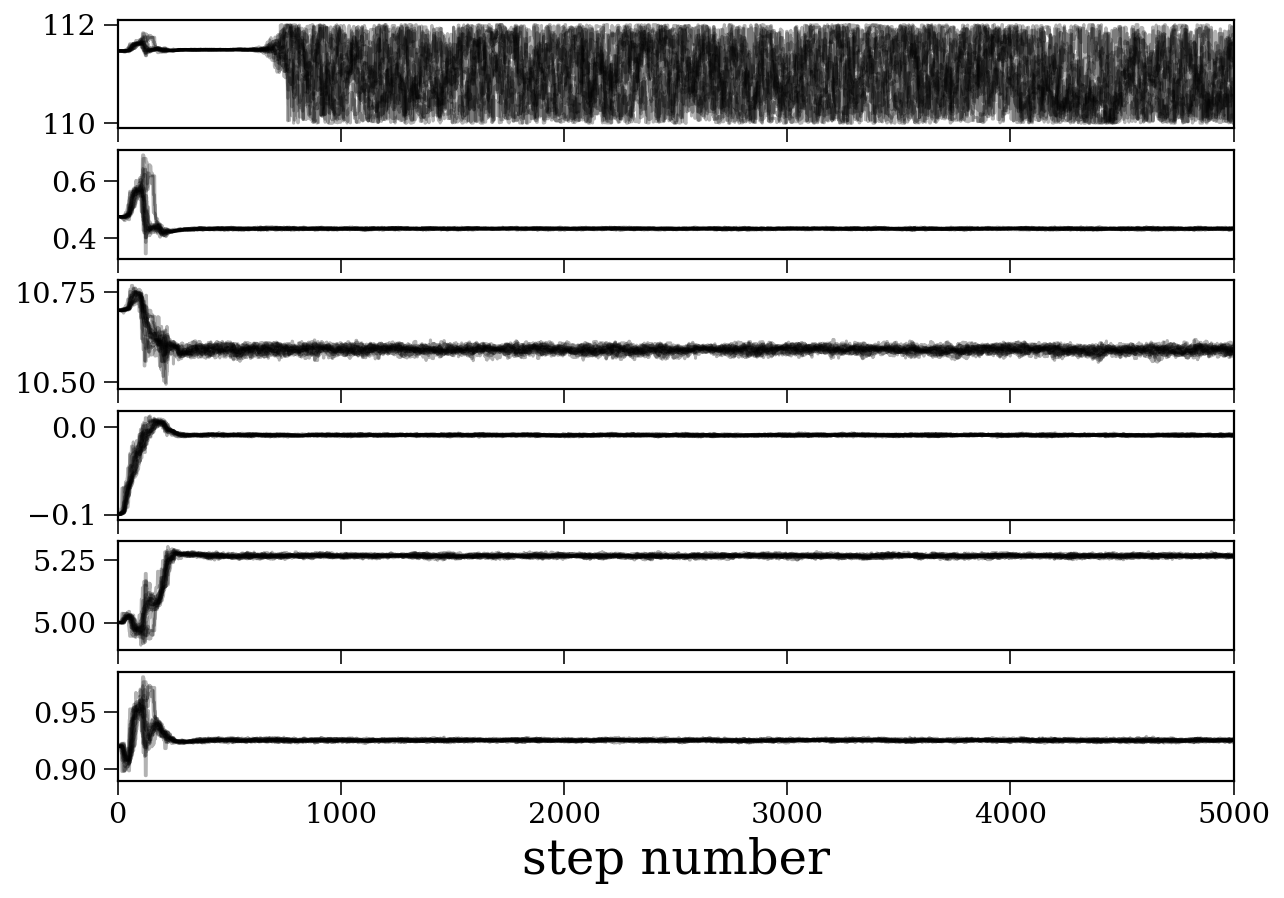

In [57]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    # ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [68]:
samples = sampler.get_chain(discard=1000, flat=True)

array([ 1.10983660e+02,  4.32284732e-01,  1.05908190e+01, -8.88645671e-03,
        5.26632481e+00,  9.25234047e-01])

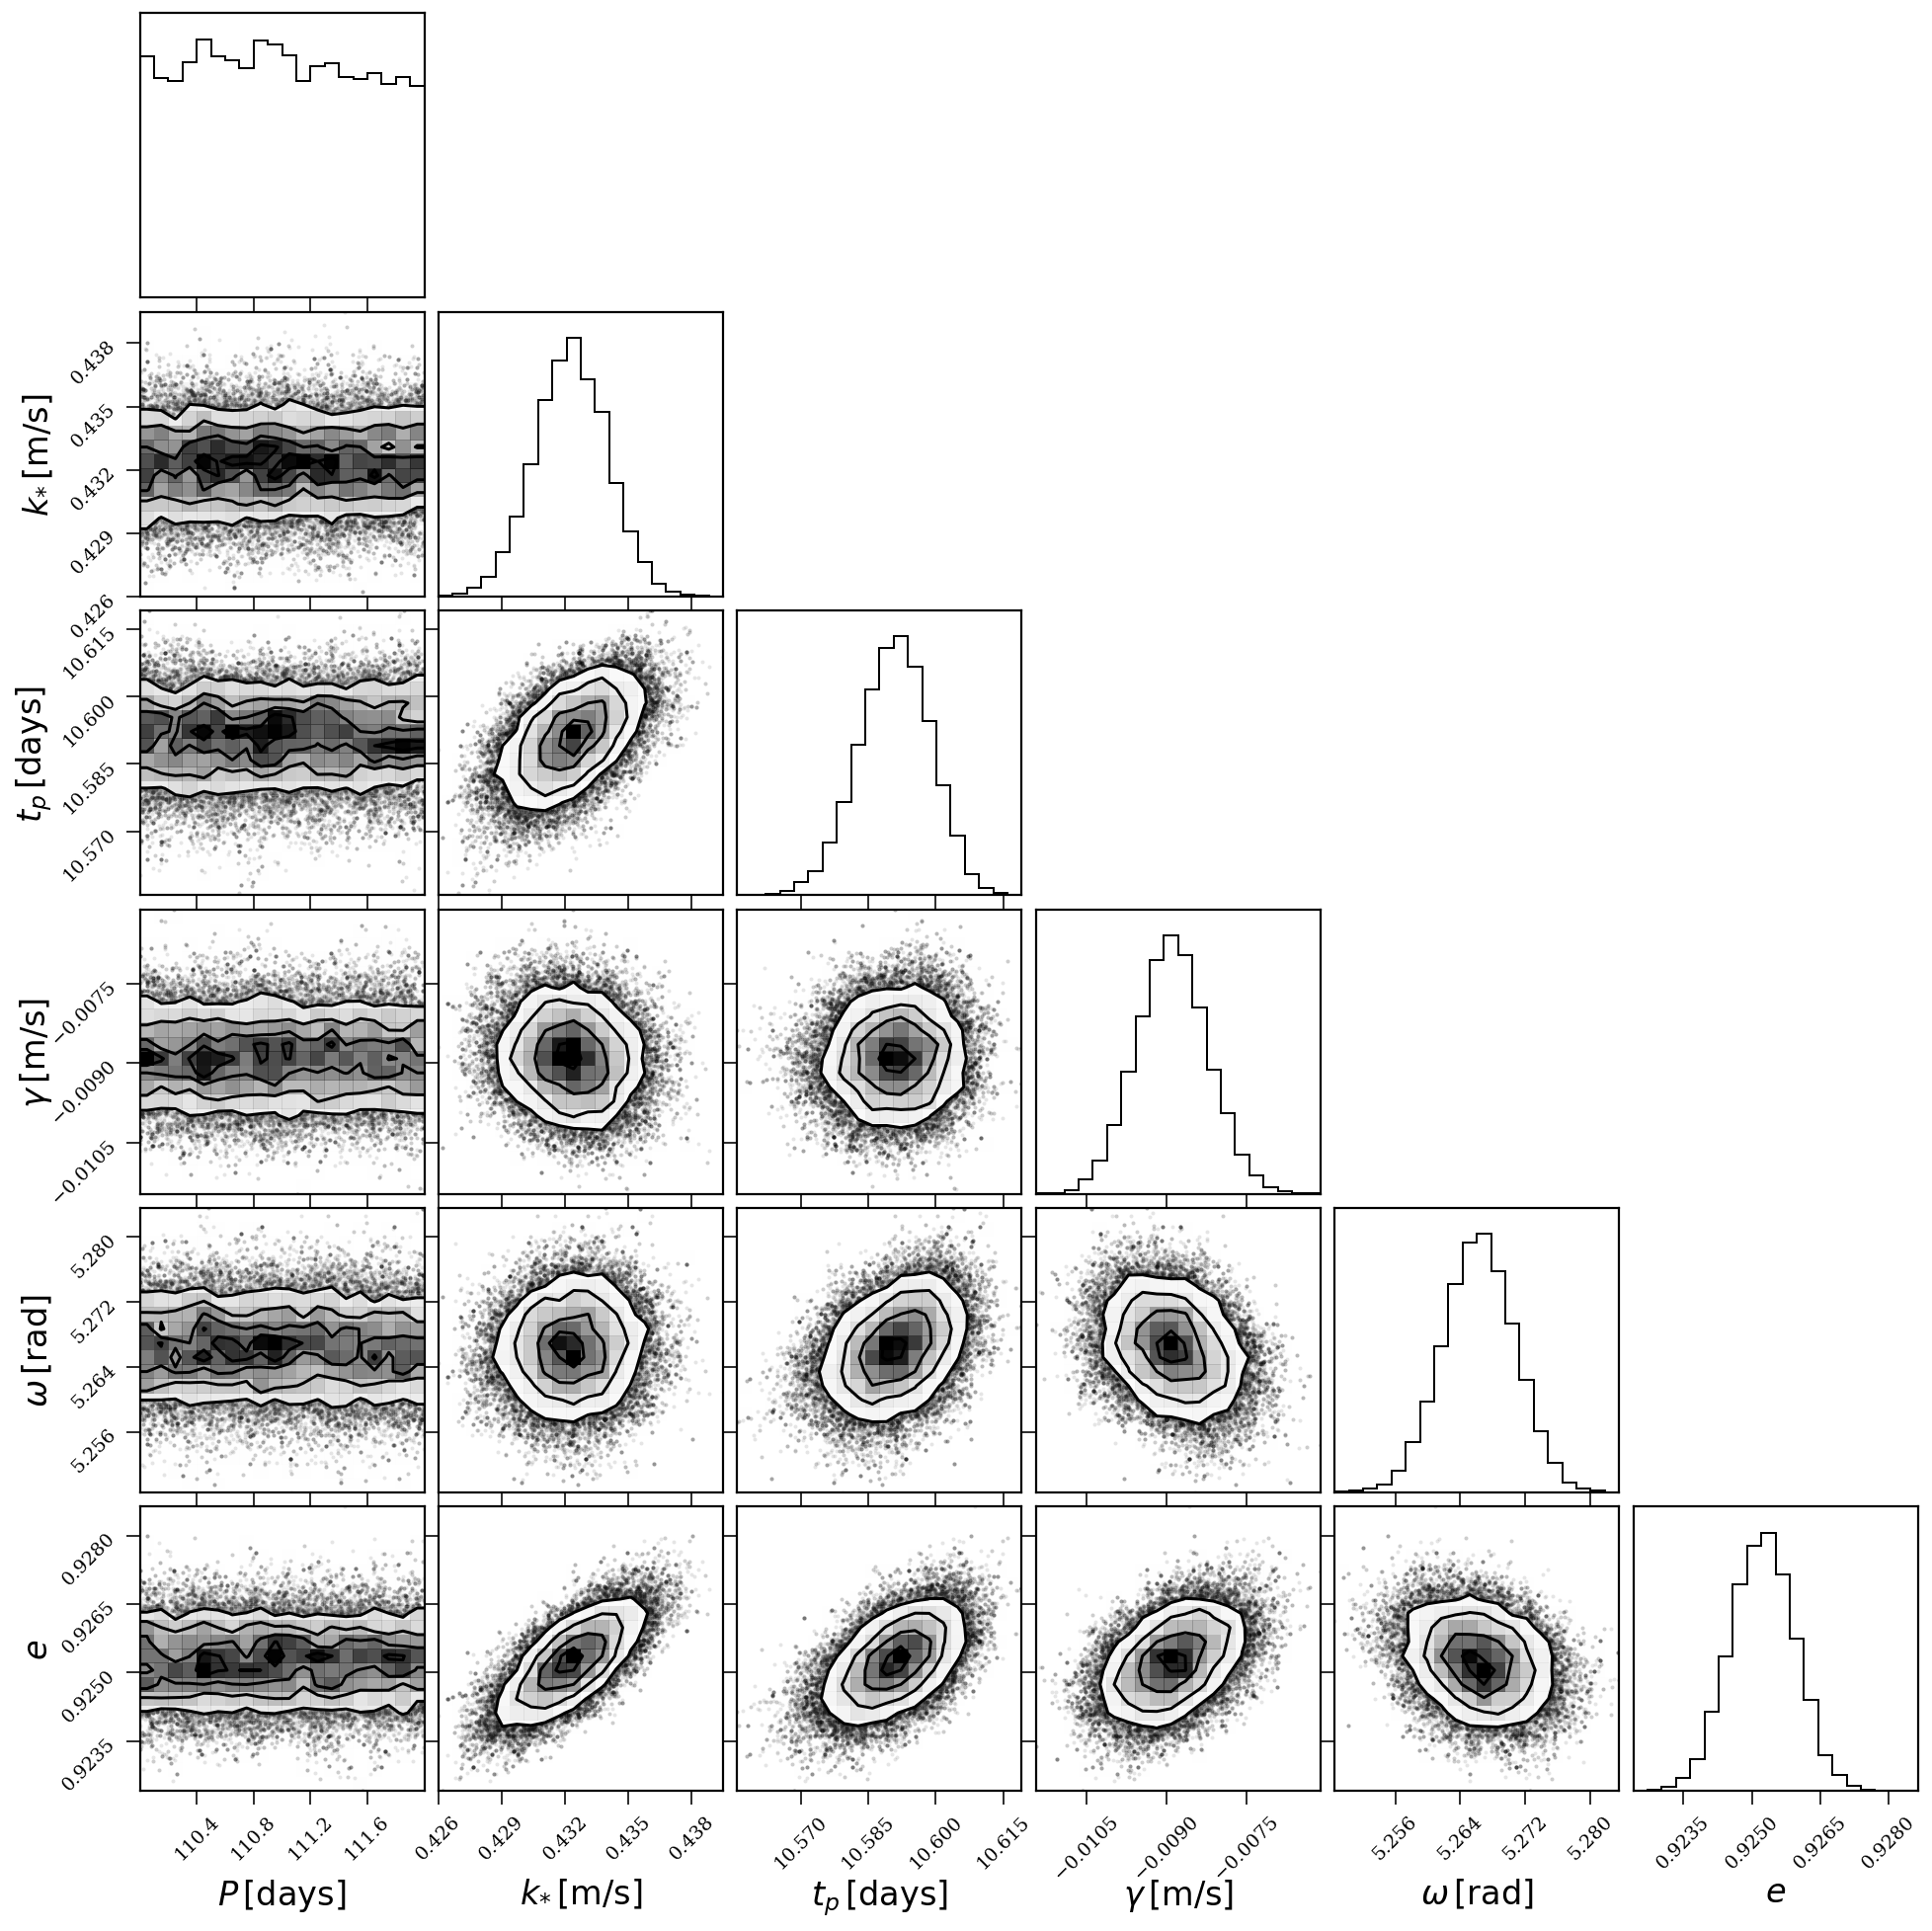

In [69]:
import corner

# update various fontsizes to match
params = {'axes.labelsize': 0.7*fs,
          'xtick.labelsize': 0.4 * fs,
          'ytick.labelsize': 0.4 * fs,}
plt.rcParams.update(params)

fig = corner.corner(
    samples, labels=[r"$P\, [{\rm days}]$", r"$k_{*}\, [{\rm m/s}]$", r"$t_p\, [{\rm days}]$", r"$\gamma\, [{\rm m / s}]$", r"$\omega \, [{\rm rad}]$", r"$e$"]
);

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.6 * fs,
          'ytick.labelsize': 0.6 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

samples.mean(axis=0)

In [74]:
fit=np.median(samples, axis=0)
# fit[0] = initial_guesses[0]

In [62]:
david_fit = [period, 0.47, 10.92, -0.04, 5.25, 0.932]

In [75]:
model_times = np.linspace(0, period, 1000)
model_rvs = get_rvs(model_times, *fit)#P=fit[0], k_star=fit[1], t_p=fit[1], gamma=fit[2], omega=fit[3], e=fit[4])

In [76]:
# refold based on fit

period = fit[0]
print(period)

data_times = planet["time"] % period
order = np.argsort(data_times)
data_times = data_times[order]
data_rvs = planet["rv"][order].values
data_errors = planet["error"][order].values

110.96815045308726


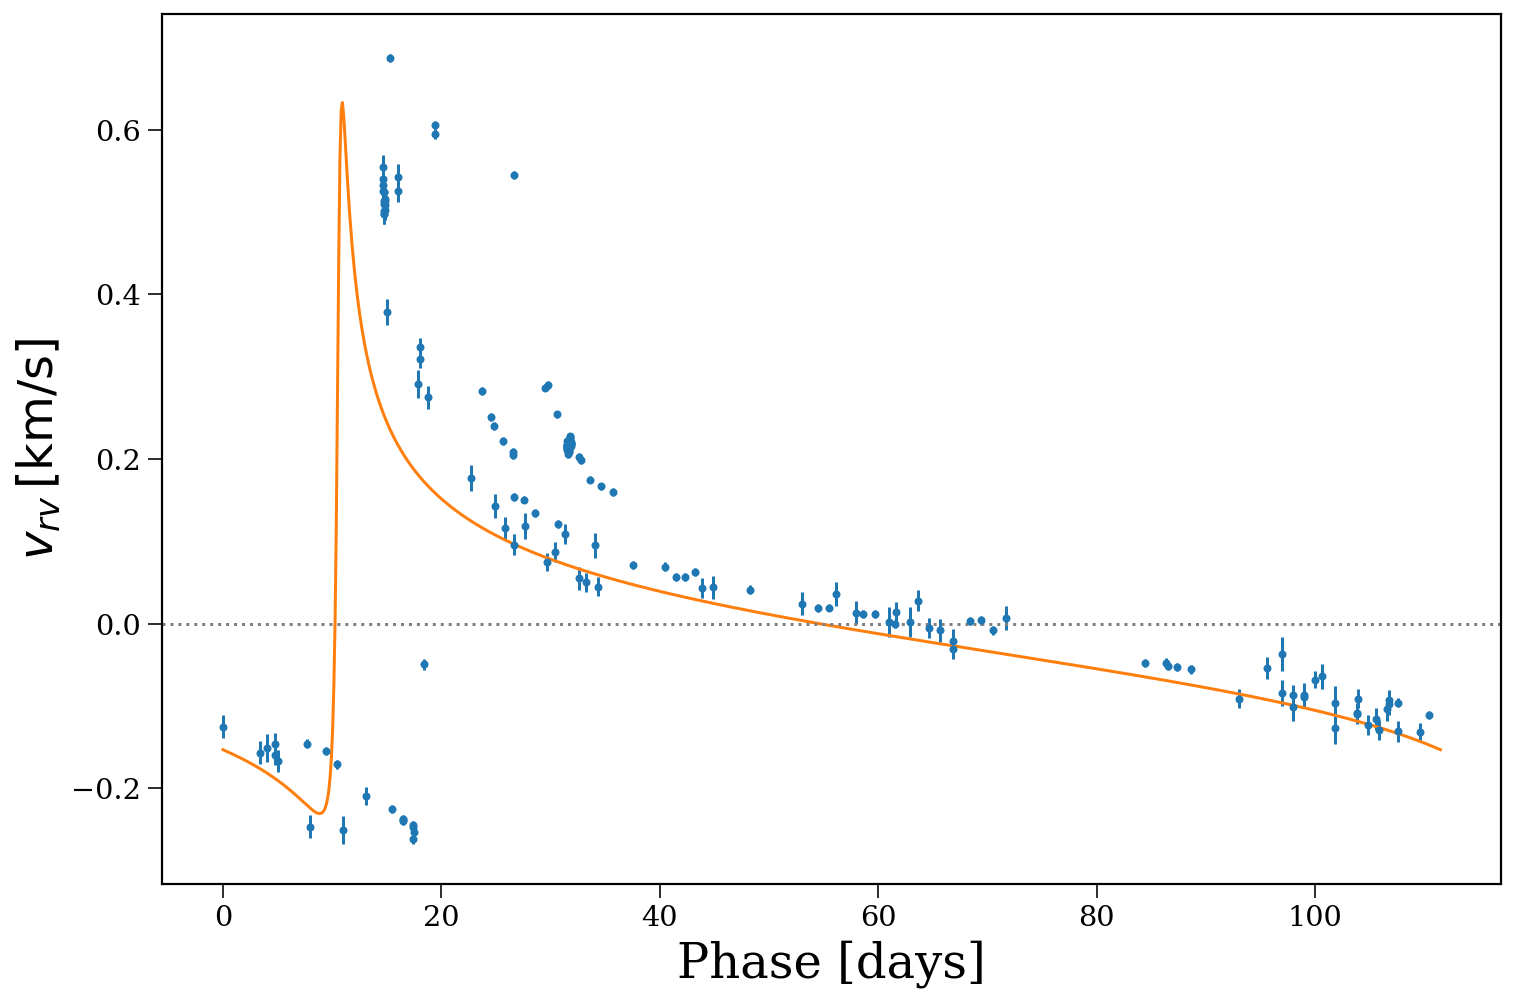

In [77]:
fig, ax = plt.subplots()

ax.errorbar(x=data_times, y=data_rvs, yerr=data_errors, fmt=".")
plt.plot(model_times, model_rvs)

ax.axhline(0, color="grey", linestyle="dotted")

ax.set_xlabel("Phase [days]")
ax.set_ylabel(r"$v_{rv} \, [{\rm km /s}]$")

plt.show()